In [35]:
import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
from tqdm.notebook import tqdm
from shapely.geometry import box, shape
from rasterio.transform import rowcol, xy
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Function to calculate MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

# Load the 2010 data
pixel_df_2010 = gpd.read_file("pixel_df/pixel_df_2010.shp")

# Correct the column names in pixel_df_2010 to match the correct names
column_name_mapping = {
    'MODIS_band': 'MODIS_band_1',
    'MODIS_ba_1': 'MODIS_band_2',
    'MODIS_ba_2': 'MODIS_band_3',
    'MODIS_ba_3': 'MODIS_band_4',
    'MODIS_ba_4': 'MODIS_band_5',
    'MODIS_ba_5': 'MODIS_band_6',
    'MODIS_ba_6': 'MODIS_band_7',
    'building_c': 'building_count',
    'building_1': 'building_coverage',
    'sqrt_build': 'sqrt_building_count',
    'sqrt_bui_1': 'sqrt_building_coverage',
    'predicted_': 'predicted_count',
    'predicte_1': 'predicted_coverage',
}
pixel_df_2010.rename(columns=column_name_mapping, inplace=True)


Model Evaluation on New Data:
Building Count:
RMSE: 11.32838556348755
R^2: 0.9928319711593776
MAPE: 259.42716058442517



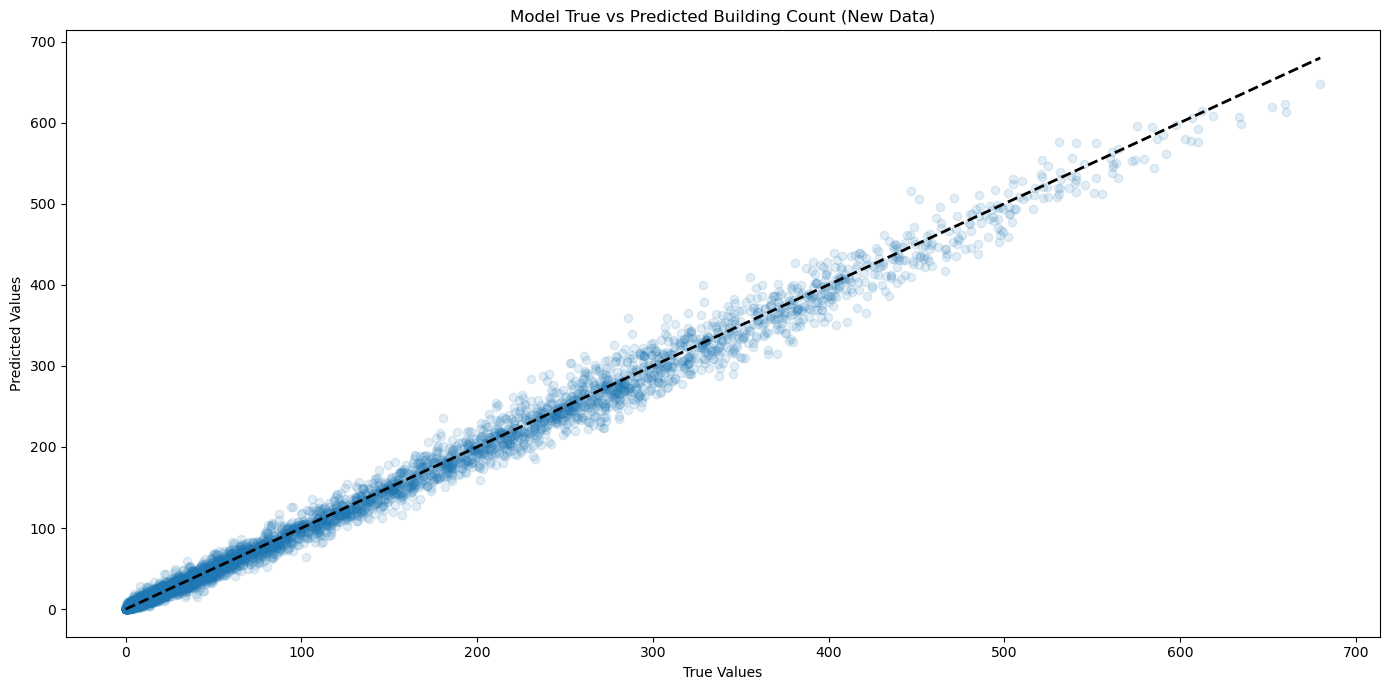

In [41]:
# Path to the new TIFF file
tiff_file_path = 'cropped_yearly_counts_and_coverage/MOD09A1_annual_mean_2010_Building_Count.tif'

# Read the new TIFF file and create a DataFrame
with rasterio.open(tiff_file_path) as src:
    data = src.read(1)  # Read the first (and only) band
    transform = src.transform
    crs = src.crs

# Mask invalid data
valid_pixels_mask = ~np.isnan(data)
valid_row_indices, valid_col_indices = np.where(valid_pixels_mask)
valid_data = data[valid_pixels_mask]

# Apply square root transformation to the building counts
# valid_data_sqrt = np.sqrt(valid_data)
valid_data_sqrt = np.square(valid_data)
# valid_data_sqrt = valid_data

# Create geometries for the valid pixels
pixel_polygons = [
    box(
        *xy(transform, row, col, offset='ul'), 
        *xy(transform, row + 1, col + 1, offset='ul')
    ) for row, col in zip(valid_row_indices, valid_col_indices)
]

# Create a GeoDataFrame for the new building count data
new_building_count_df = gpd.GeoDataFrame({'geometry': pixel_polygons, 'building_count_new': valid_data_sqrt}, crs=crs)

# Compare and align geometries of both GeoDataFrames
aligned_pixel_df_2010 = pixel_df_2010.set_index('geometry').join(new_building_count_df.set_index('geometry'), rsuffix='_new')
aligned_pixel_df_2010 = aligned_pixel_df_2010.dropna().reset_index()

# Extract relevant data
y_pred = aligned_pixel_df_2010['building_count_new']
y_true = aligned_pixel_df_2010['predicted_count']

# Evaluation metrics for the new data
print("Model Evaluation on New Data:")
print("Building Count:")
print(f"RMSE: {mean_squared_error(y_true, y_pred, squared=False)}")
print(f"R^2: {r2_score(y_true, y_pred)}")
print(f"MAPE: {calculate_mape(y_true, y_pred)}\n")

# Scatter plot of true vs predicted values
plt.figure(figsize=(14, 7))
plt.scatter(y_true, y_pred, alpha=0.125)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'k--', lw=2)
plt.title('Model True vs Predicted Building Count (New Data)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.tight_layout()
plt.savefig('comparison.png')


AttributeError: Line2D.set() got an unexpected keyword argument 'vmin'

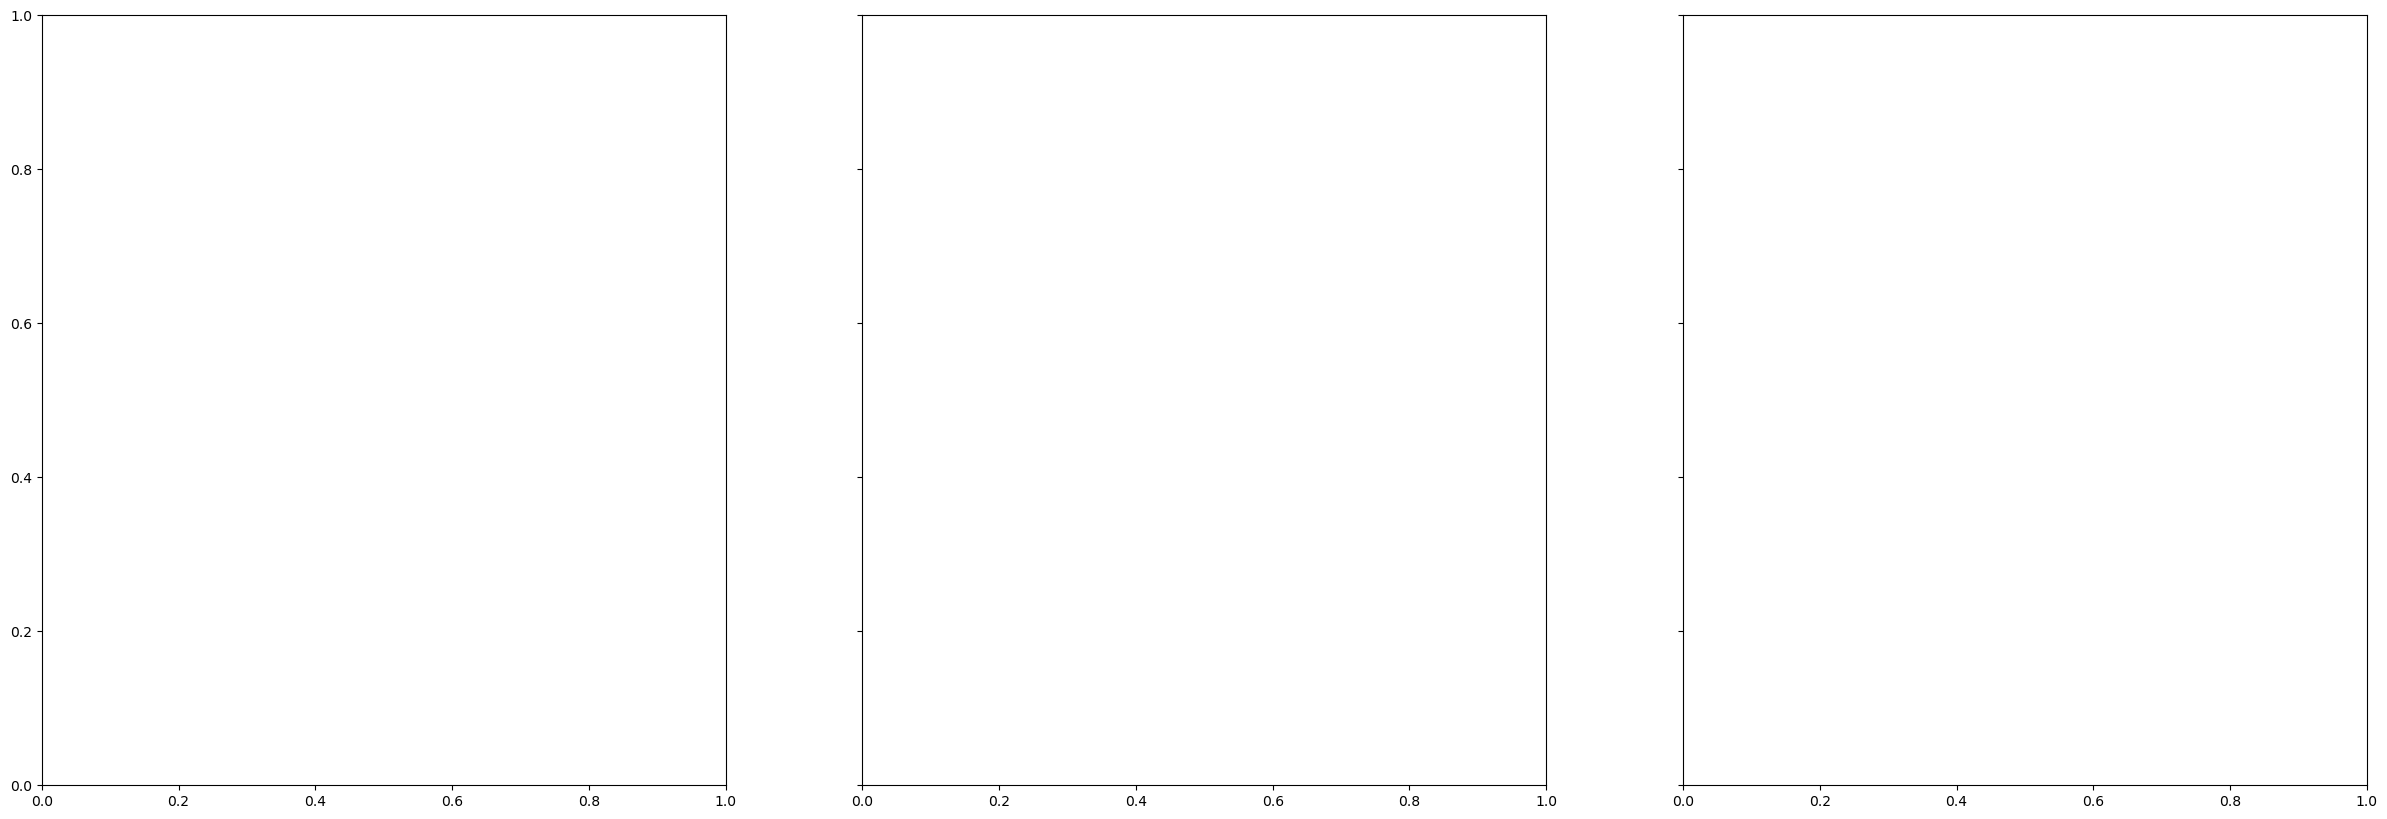

In [37]:
# Function to plot true, predicted, and error values spatially
def plot_true_predicted_error_new(gdf, true_column, pred_column, true_title, pred_title, error_title, cmap_true_pred='viridis', cmap_error='coolwarm'):
    """
    Plot the true, predicted values, and error of a specific column of the GeoDataFrame.
    
    Parameters:
    - gdf: GeoDataFrame to plot.
    - true_column: The name of the column with true values.
    - pred_column: The name of the column with predicted values.
    - true_title: The title of the plot for true values.
    - pred_title: The title of the plot for predicted values.
    - error_title: The title of the plot for the error.
    - cmap_true_pred: The colormap to use for true and predicted values.
    - cmap_error: The colormap to use for the error values.
    """
    fig, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)

    # Find common range for colorbar for true and predicted values
    vmin_true_pred = min(gdf[true_column].min(), gdf[pred_column].min())
    vmax_true_pred = max(gdf[true_column].max(), gdf[pred_column].max())
    
    # Plot true values
    true_plot = gdf.plot(column=true_column, ax=axes[0], cmap=cmap_true_pred, vmin=vmin_true_pred, vmax=vmax_true_pred)
    axes[0].set_title(true_title)
    axes[0].axis('off')
    
    # Plot predicted values
    pred_plot = gdf.plot(column=pred_column, ax=axes[1], cmap=cmap_true_pred, vmin=vmin_true_pred, vmax=vmax_true_pred)
    axes[1].set_title(pred_title)
    axes[1].axis('off')

    # Calculate error and plot
    gdf['error'] = gdf[true_column] - gdf[pred_column]
    vmax_error = np.max(np.abs(gdf['error']))
    error_plot = gdf.plot(column='error', ax=axes[2], cmap=cmap_error, vmin=-vmax_error, vmax=vmax_error)
    axes[2].set_title(error_title)
    axes[2].axis('off')
    
    # Set the colorbar for true and predicted on the first subplot
    divider_true_pred = make_axes_locatable(axes[1])
    cax_true_pred = divider_true_pred.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(pred_plot.get_children()[0], cax=cax_true_pred, ax=[axes[0], axes[1]])
    
    # Set the colorbar for error on the third subplot
    divider_error = make_axes_locatable(axes[2])
    cax_error = divider_error.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(error_plot.get_children()[0], cax=cax_error, ax=axes[2])
    
    # Tighten up layout
    plt.tight_layout()
    plt.show()

# Assuming aligned_pixel_df_2010 includes 'building_count_new' and 'predicted_count'
plot_true_predicted_error_new(
    aligned_pixel_df_2010,
    'building_count_new',
    'predicted_count',
    'True Building Count (New Data)',
    'Predicted Building Count (New Data)',
    'Error in Building Count (New Data)',
    cmap_true_pred='YlGnBu',
    cmap_error='coolwarm'
)
